# License

    Jupyter notebook for accessing CUDA
    Copyright (C) 2018 Andre.Brodtkorb@ifi.uio.no, changed in October by Francesco Colombi

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [8]:
#Lets have matplotlib "inline"
%matplotlib inline

#Import packages we need
import numpy as np
import pycuda.compiler as cuda_compiler
from pycuda.gpuarray import GPUArray
import pycuda.driver as cuda_driver

from matplotlib import pyplot as plt

In [9]:
#Initialize CUDA - must be first call to CUDA!
cuda_driver.init()

In [10]:
#Create CUDA context
cuda_device = cuda_driver.Device(0)
print("Using '{:s}'".format(cuda_device.name()))
print(" => compute capability: {:s}".format(str(cuda_device.compute_capability())))
context = cuda_device.make_context()
free, total = cuda_driver.mem_get_info()
print(" => memory: {:d} / {:d} MB available".format(int(free/(1024*1024)), int(total/(1024*1024))))

Using 'Tesla K80'
 => compute capability: (3, 7)
 => memory: 10333 / 11441 MB available


In [49]:
cuda_kernel = """
__global__ void addVectorKernel(float* c, float* a, float* b) {
    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;
    c[i] = a[i] + b[i];
}

__global__ void addMatrixKernel(float* c, float* a, float* b, int cols){
    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;
    unsigned int j = blockIdx.y*blockDim.y + threadIdx.y;
    
    //Pseudocode
    //c[j][i] = a[j][i] + b[j][i]
    unsigned int k = j*cols + i;
    
    c[k] = a[k] + b[k];
}
"""
module = cuda_compiler.SourceModule(cuda_kernel)
kernel = module.get_function("addMatrixKernel");

/usr/lib/python3/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


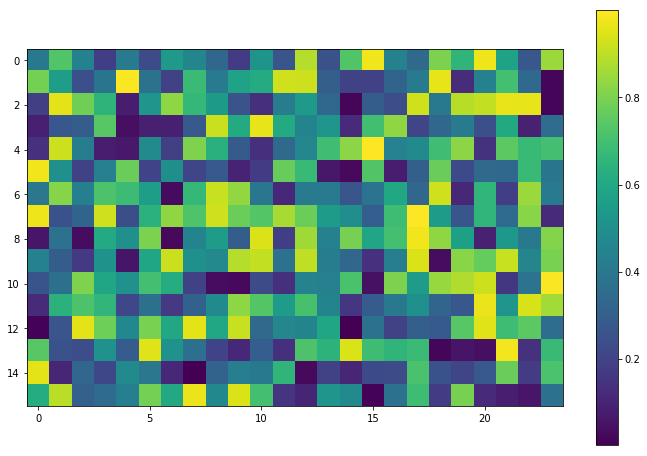

In [50]:
#Size of our test
test_size = (16,24)

#Create test input / output data
a = np.random.random(test_size).astype(np.float32)
b = np.random.random(test_size).astype(np.float32)
c = np.empty_like(a)

fig = plt.figure(figsize=(12,8))
plt.imshow(a)
plt.colorbar()
fig.show()

In [51]:
print(a.shape)

(16, 24)


In [52]:
#Upload data to the device
a_g = GPUArray(a.shape, np.float32)
b_g = GPUArray(b.shape, np.float32)
a_g.set(a)
b_g.set(b)

In [53]:
#Allocate output data
c_g = GPUArray(c.shape, np.float32)

In [54]:
# a.shape = [rows, colums] => [y, x]
main_size = (a.shape[1], a.shape[0]) # now domain size is [x, y]
block_size = (8,8,1) # this needs to be [x, y, z]
grid_size = (domain_size[0] // block_size[0], domain_size[1] // block_size[1], 1)

print("Domain size is " + str(domain_size))
print("Block size is " + str(block_size))
print("Grid size is " + str(grid_size))

Domain size is (16, 24)
Block size is (8, 8, 1)
Grid size is (2, 3, 1)


In [55]:
#Execute program on device
kernel(c_g, a_g, b_g, np.int32(domain_size[0]), block=block_size, grid=grid_size)

#Copy data from device to host
c_g.get(c)

array([[0.45990768, 0.91668046, 1.4105393 , 0.34745952, 0.65285075,
        1.0225117 , 1.2362087 , 1.133173  , 0.9340662 , 0.637317  ,
        1.200995  , 0.82654405, 1.1859999 , 0.77612376, 1.6129279 ,
        1.7529459 , 0.5582305 , 1.0733318 , 1.4718173 , 1.1217893 ,
        1.1844687 , 0.8559757 , 0.8998289 , 1.534611  ],
       [1.4479098 , 0.87356955, 1.1927493 , 1.1864641 , 1.3501916 ,
        0.80959284, 0.6019679 , 0.78286666, 0.63254   , 0.9127934 ,
        0.75062   , 1.8714418 , 1.5994339 , 0.34411883, 0.77178884,
        0.88815224, 1.110222  , 1.0765537 , 1.0508207 , 0.15937391,
        0.8625333 , 1.3581523 , 0.8173598 , 0.2816632 ],
       [0.359751  , 1.6009248 , 1.6448321 , 0.7693787 , 0.9887101 ,
        1.3966262 , 0.86131763, 0.8887792 , 1.4666501 , 0.48549402,
        0.573619  , 1.2627279 , 0.88126844, 1.1412994 , 0.9729474 ,
        0.6566421 , 1.115652  , 0.9370789 , 1.1911966 , 1.6037444 ,
        0.9712978 , 1.4081848 , 1.826003  , 0.9271424 ],
       [0.688

In [56]:
#Compute reference using Numpy
c_ref = a + b

#Print result
print("C   = ", c)
print("Ref = ", c_ref)
print("Sad = ", np.sum(np.abs(c - c_ref)))

C   =  [[0.45990768 0.91668046 1.4105393  0.34745952 0.65285075 1.0225117
  1.2362087  1.133173   0.9340662  0.637317   1.200995   0.82654405
  1.1859999  0.77612376 1.6129279  1.7529459  0.5582305  1.0733318
  1.4718173  1.1217893  1.1844687  0.8559757  0.8998289  1.534611  ]
 [1.4479098  0.87356955 1.1927493  1.1864641  1.3501916  0.80959284
  0.6019679  0.78286666 0.63254    0.9127934  0.75062    1.8714418
  1.5994339  0.34411883 0.77178884 0.88815224 1.110222   1.0765537
  1.0508207  0.15937391 0.8625333  1.3581523  0.8173598  0.2816632 ]
 [0.359751   1.6009248  1.6448321  0.7693787  0.9887101  1.3966262
  0.86131763 0.8887792  1.4666501  0.48549402 0.573619   1.2627279
  0.88126844 1.1412994  0.9729474  0.6566421  1.115652   0.9370789
  1.1911966  1.6037444  0.9712978  1.4081848  1.826003   0.9271424 ]
 [0.688645   0.49853587 0.67257965 0.9814639  0.45328414 0.46270835
  0.15742949 0.3669272  1.2113396  0.7185572  1.1955653  0.88171893
  0.651254   1.3814315  1.0832672  1.1451291 

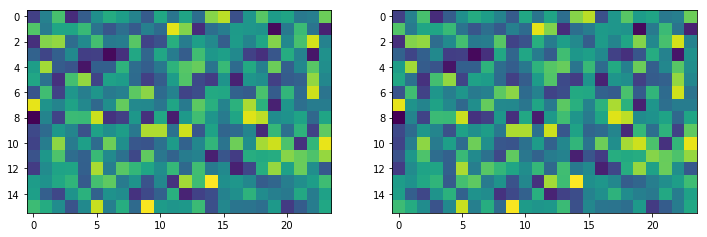

In [57]:
fig = plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(c)
plt.subplot(1,2,2)
plt.imshow(c_ref)